In [1]:
import netCDF4 as nc
import numpy as np
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
#import shapefile
import pandas as pd
#from shapely.geometry import Point, Polygon
import os


In [2]:
# LISTA DE ARCHIVOS DE LOS ULTIMOS 10 DIAS

dates_list = []
doy_list = []
yesterday = datetime.now() - timedelta(days=1)
ndays = 10
for i in range(ndays):
    date = yesterday - timedelta(days=i)
    year = date.strftime('%Y')
    doy = date.strftime('%j')
    date_str = year + doy
    dates_list.append(date_str)
    doy_list.append(int(doy))

    # A MODO DE EJEMPLO
print(dates_list)
dates_list = ['2024109']

['2024171', '2024170', '2024169', '2024168', '2024167', '2024166', '2024165', '2024164', '2024163', '2024162']


In [3]:
# DEFINIR RUTA DE LOS ARCHIVOS NETCDF DE ENTRADA Y SALIDA

inputdatapath = "./rclone/MSWX/"

dt = datetime.now()
date_str = dt.strftime('%Y%b%d').capitalize()
newfolder = date_str
outputpath = os.path.join("./outputdata/ET0", newfolder)
os.makedirs(outputpath, exist_ok=True)


In [4]:
#pressure = 101.3 * ((293 - 0.0065 * altitud) / 293) ** 5.26
pressure = 101.325 # PRESION DE ATMOSFERA STANDARD


In [5]:
# ARCHIVO MASK HONDURAS, 0s y 1s, archivo creado previamente 
mask_file = './mask_honduras/mask_mswx_hnd.nc4'
nc_file = nc.Dataset(mask_file)
lat = nc_file.variables["lat"][:]
lon = nc_file.variables["lon"][:]
mask = nc_file.variables["mask"][:]

#plt.imshow(mask, extent=[lon.min(), lon.max(), lat.min(),lat.max()])
#plt.ylim([12, 17])
#plt.xlim([-90, -83])
#plt.show()


In [8]:
# Inicializa una lista para almacenar los datos de ET0 con dimensión temporal
ET0_list = []

count = -1

for t in dates_list:
    
    print('Archivos ' +  str(int(t)) + '.nc')
    
    print('Leyendo datos de entrada')
    tmax_file = nc.Dataset(inputdatapath + "Tmax/" + str(int(t)) + ".nc")
    tmax = tmax_file.variables["air_temperature"][:]
    tmax = tmax[0,:, :]
    
    tmin_file = nc.Dataset(inputdatapath + "Tmin/" + str(int(t)) + ".nc")
    tmin = tmin_file.variables["air_temperature"][:]
    tmin = tmin[0,:, :]
    
    temperature = (tmax + tmin)/2
    
    rh_file = nc.Dataset(inputdatapath + "RelHum/" + str(int(t)) + ".nc")
    humidity = rh_file.variables["relative_humidity"][:]
    humidity = humidity[0,:, :]
    
    wind_file = nc.Dataset(inputdatapath + "Wind/" + str(int(t)) + ".nc")
    wind_speed = wind_file.variables["wind_speed"][:]
    wind_speed = wind_speed[0,:, :]
    
    swd_file = nc.Dataset(inputdatapath + "SWd/" + str(int(t)) + ".nc")
    solar_radiation = swd_file.variables["downward_shortwave_radiation"][:]
    solar_radiation = solar_radiation[0,:, :]
    
    rows = np.size(lat)
    cols = np.size(lon)
    myET0 = np.empty((rows, cols))
    myET0[:] = np.nan
    
    count = count + 1
    doy = doy_list[count]
    
    print('Calculando ET0')
    for i in range(len(lat)):
        
        for j in range(len(lon)):
            
            if mask[i,j] == 1:
                
                mytas = temperature[i,j]
                myrh = humidity[i,j]
                myws = wind_speed[i,j]
                mysr = solar_radiation[i,j]*0.0864 # W/m2 to MJ/m2/d
                
                # PRESION DE VAPOR A SATURACION Y ACTUAL
                es = 0.6108 * math.exp(17.27 * mytas / (mytas + 237.3))
                ea = (myrh / 100) * es
                
                # PENDIENTE DE LA CURVA DE PRESION DE VAPOR Y CONSTANTE PSICROMETRICA
                delta = 4098 * es / (mytas + 237.3) ** 2
                gamma = 0.665 * 10 ** (-3) * pressure / 0.622
                
                latitude = lat[i]
                                
                # RADIACION SOLAR DE DIA DESPEJADO Y RADIACION EXTRATERRESTRE
                dr = 1 + 0.033 * math.cos(2 * math.pi / 365 * doy)
                delta_s = 0.409 * math.sin(2 * math.pi / 365 * doy - 1.39)
                omega_s = math.acos(-math.tan(latitude * math.pi / 180) * math.tan(delta_s))
                Ra = (24 * 60 / math.pi) * 0.082 * dr * (omega_s * math.sin(latitude * math.pi / 180) * math.sin(delta_s) + math.cos(latitude * math.pi / 180) * math.cos(delta_s) * math.sin(omega_s))
                
                # RADIACION SOLAR NETA Y RADIACION NETA DE ONDA LARGA EMERGENTE
                Rns = 0.77 * mysr
                Rnl = 4.903 * 10 ** (-9) * ((mytas + 273.16) ** 4) * (0.34 - 0.14 * math.sqrt(ea)) * (1.35 * (mysr / Ra) - 0.35)
                
                Rn = Rns - Rnl
                G = 0 # A ESCALA DIARIA = 0
                
                # ET0
                ET0 = (0.408 * delta * (Rn - G) + gamma * (900 / (mytas + 273)) * myws * (es - ea)) / (delta + gamma * (1 + 0.34 * myws))

                myET0[i][j] = ET0
                
    lat_min = 12.5
    lat_max = 16.5
    lon_min = -90
    lon_max = -83
    
    lon_indices = np.nonzero((lon >= lon_min) & (lon <= lon_max))[0]
    lat_indices = np.nonzero((lat >= lat_min) & (lat <= lat_max))[0]
    myET0 = np.array(myET0)
    region_data = myET0[np.ix_(lat_indices, lon_indices)]
    region_lats = lat[lat_indices]
    region_lons = lon[lon_indices]

    # Añadir el ET0 de la región a la lista
    ET0_list.append(region_data)
    
print('Creando archivo de salida')
# Convertir la lista de ET0 a un array numpy con una dimensión de tiempo
ET0_array = np.array(ET0_list)

# Sumar los valores a lo largo de la dimensión temporal
ET0_sum = np.sum(ET0_array, axis=0)

myfile = outputpath + "/ET0.nc"
ncfile = nc.Dataset(myfile, "w", format="NETCDF4")
ncfile.createDimension('lon', len(region_lons))
ncfile.createDimension('lat', len(region_lats))
ncfile.createDimension('time', len(dates_list))

lon_var = ncfile.createVariable('lon', np.float32, ('lon',))
lat_var = ncfile.createVariable('lat', np.float32, ('lat',))
time_var = ncfile.createVariable('time', np.float32, ('time',))
data_var = ncfile.createVariable('ET0', np.float32, ('time', 'lat', 'lon'))
sum_var = ncfile.createVariable('ET0_sum', np.float32, ('lat', 'lon'))

lon_var.units = 'degrees_east'
lon_var.long_name = 'Geographic longitude'
lat_var.units = 'degrees_north'
lat_var.long_name = 'Geographic latitude'
time_var.units = 'days since 1900-01-01 00:00:00'
time_var.long_name = 'Time'
data_var.units = 'mm/day'
data_var.long_name = 'FAO-56 Penman-Monteith reference evapotranspiration'
sum_var.units = 'mm/day'
sum_var.long_name = 'Sum of FAO-56 Penman-Monteith reference evapotranspiration over time'

ncfile.author = 'CGIAR-AgriLAC, CENAOS-COPECO'
ncfile.originaldata = 'MSWX Near Real Time'
ncfile.created = datetime.now().strftime('%Y-%m-%d')

lon_var[:] = region_lons
lat_var[:] = region_lats
time_var[:] = [int(t) for t in dates_list]
data_var[:] = ET0_array
sum_var[:] = ET0_sum

ncfile.close()
                
print('Listo')


Archivos 2024109.nc
Leyendo datos de entrada
Calculando ET0
Creando archivo de salida
Listo


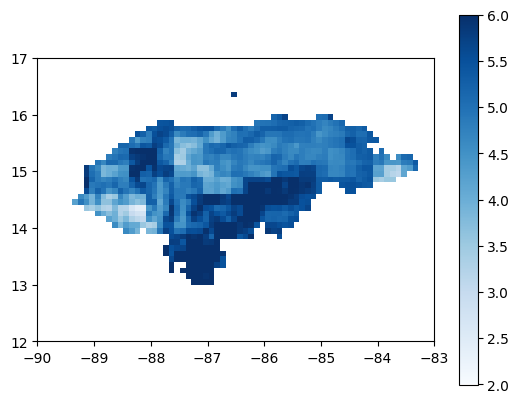

In [7]:
fig, ax = plt.subplots()
im = plt.imshow(myET0, extent=[lon.min(), lon.max(), lat.min(),lat.max()],cmap='Blues')
plt.clim(2,6)
plt.ylim([12, 17])
plt.xlim([-90, -83])
cb = fig.colorbar(im)
plt.show()
